<a href="https://colab.research.google.com/github/salochaud/aprendizajeautomatico/blob/main/Tarea8_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import math

plt.rcParams["figure.figsize"] = (8, 5)

df = pd.read_csv('/content/database_24_25.csv')

display(df.head())
print(df.columns)

feature_cols = [
    'MP','FG','FGA','FG%','3P','3PA','3P%',
    'FT','FTA','FT%','ORB','DRB','TRB',
    'AST','STL','BLK','TOV','PF','PTS'
]
target_col = 'GmSc'

df_model = df[feature_cols + [target_col]].dropna()
print("Shape después de dropna:", df_model.shape)

# Escalado de variables
scaler = StandardScaler()
scaled = scaler.fit_transform(df_model)
df_scaled = pd.DataFrame(scaled, columns=feature_cols + [target_col])

X = df_scaled[feature_cols]
y = df_scaled[target_col]

# Separar en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

X_train.shape, X_test.shape

,Player,Tm,Opp,Res,MP,FG,FGA,FG%,3P,3PA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,Data
0,Jayson Tatum,BOS,NYK,W,30.30,14,18,0.778,8,11,...,4,4,10,1,1,1,1,37,38.1,2024-10-22
1,Anthony Davis,LAL,MIN,W,37.58,11,23,0.478,1,3,...,13,16,4,1,3,1,1,36,34.0,2024-10-22
2,Derrick White,BOS,NYK,W,26.63,8,13,0.615,6,10,...,3,3,4,1,0,0,1,24,22.4,2024-10-22
3,Jrue Holiday,BOS,NYK,W,30.52,7,9,0.778,4,6,...,2,4,4,1,0,0,2,18,19.5,2024-10-22
4,Miles McBride,NYK,BOS,L,25.85,8,10,0.800,4,5,...,0,0,2,0,0,1,1,22,17.8,2024-10-22


Index(['Player', 'Tm', 'Opp', 'Res', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA',
       '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS', 'GmSc', 'Data'],
      dtype='object')
Shape después de dropna: (16512, 20)


((12384, 19), (4128, 19))

In [3]:
# Función auxiliar para calcular métricas de desempeño

def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, mape, r2

In [4]:
# Comparación inicial: Regresión Lineal vs Random Forest (modelo base)

results_baseline = []

# Modelo 1: Regresión Lineal
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mae, mse, rmse, mape, r2 = compute_metrics(y_test, y_pred_lr)
results_baseline.append(['LinearRegression', mae, mse, rmse, mape, r2])

# Modelo 2: Random Forest base
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train, y_train)
y_pred_rf = rf_base.predict(X_test)
mae, mse, rmse, mape, r2 = compute_metrics(y_test, y_pred_rf)
results_baseline.append(['RandomForest (base)', mae, mse, rmse, mape, r2])

df_baseline = pd.DataFrame(
    results_baseline,
    columns=['Modelo','MAE','MSE','RMSE','MAPE (%)','R2']
)
display(df_baseline)

,Modelo,MAE,MSE,RMSE,MAPE (%),R2
0,LinearRegression,7.274267e-16,9.221611e-31,9.602922e-16,4.351074e-13,1.000000
1,RandomForest (base),1.149776e-01,2.801748e-02,1.673842e-01,6.436169e+01,0.971721


In [5]:
# Diseño de experimentos: diferentes configuraciones de Random Forest
# Factor A: n_estimators = [50, 100, 200]
# Factor B: max_depth   = [None, 5, 10]

from math import isnan

n_estimators_list = [50, 100, 200]
max_depth_list = [None, 5, 10]

experiments = []
for n_est in n_estimators_list:
    for md in max_depth_list:
        model = RandomForestRegressor(
            n_estimators=n_est,
            max_depth=md,
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae, mse, rmse, mape, r2 = compute_metrics(y_test, y_pred)
        experiments.append([n_est, md, mae, mse, rmse, mape, r2])

df_exp = pd.DataFrame(
    experiments,
    columns=['n_estimators','max_depth','MAE','MSE','RMSE','MAPE (%)','R2']
)

display(df_exp.sort_values('RMSE'))

,n_estimators,max_depth,MAE,MSE,RMSE,MAPE (%),R2
6,200,NaN,0.114417,0.027676,0.166362,64.024499,0.972065
3,100,NaN,0.114978,0.028017,0.167384,64.361693,0.971721
0,50,NaN,0.116447,0.028462,0.168707,64.692122,0.971272
8,200,10.0,0.143932,0.038835,0.197065,81.405458,0.960803
5,100,10.0,0.144380,0.039114,0.197773,81.709369,0.960521
2,50,10.0,0.145440,0.039706,0.199263,81.404682,0.959924
4,100,5.0,0.231845,0.095985,0.309814,137.702437,0.903119
1,50,5.0,0.232024,0.096098,0.309997,138.156697,0.903004
7,200,5.0,0.232167,0.096155,0.310088,137.910864,0.902947


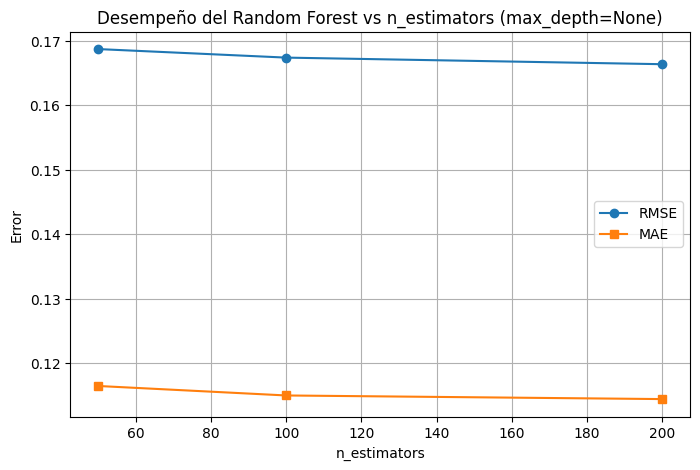

In [6]:
# Gráfica de desempeño en función de n_estimators para max_depth=None

df_md_none = df_exp[df_exp['max_depth'].isna()]  # max_depth=None aparece como NaN en DataFrame

plt.figure(figsize=(8,5))
plt.plot(df_md_none['n_estimators'], df_md_none['RMSE'], marker='o', label='RMSE')
plt.plot(df_md_none['n_estimators'], df_md_none['MAE'], marker='s', label='MAE')
plt.xlabel('n_estimators')
plt.ylabel('Error')
plt.title('Desempeño del Random Forest vs n_estimators (max_depth=None)')
plt.grid(True)
plt.legend()
plt.show()

Mejor configuración encontrada:


,n_estimators,max_depth,MAE,MSE,RMSE,MAPE (%),R2
6,200.0,NaN,0.114417,0.027676,0.166362,64.024499,0.972065


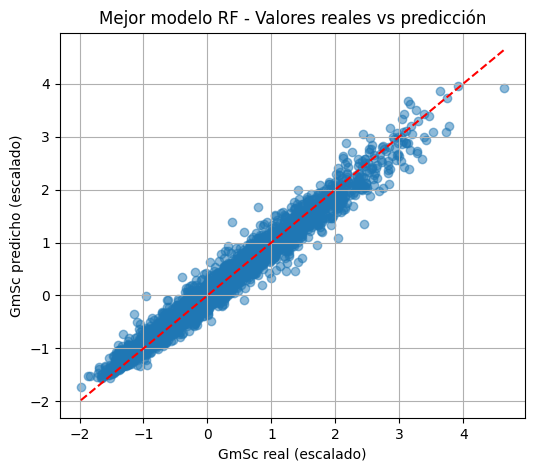

In [7]:
# Seleccionar la mejor configuración según RMSE mínimo

best_row = df_exp.loc[df_exp['RMSE'].idxmin()]
print("Mejor configuración encontrada:")
display(best_row.to_frame().T)

best_model = RandomForestRegressor(
    n_estimators=int(best_row['n_estimators']),
    max_depth=None if pd.isna(best_row['max_depth']) else int(best_row['max_depth']),
    random_state=42
)
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

# Gráfica valores reales vs predichos con el mejor modelo
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred_best, alpha=0.5)
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.xlabel('GmSc real (escalado)')
plt.ylabel('GmSc predicho (escalado)')
plt.title('Mejor modelo RF - Valores reales vs predicción')
plt.grid(True)
plt.show()